数据集来源：使用make_data_dota.py得到DOTA中含有ship的图像。本项目Dataset_cyclegan利用标签把可见光中的ship替换红外ship（背景保持不变），使构建的训练图像对中两张图的差别仅是标签处的船不同。与v3的区别是抠掉的位置不一定在红外的标签处，而是随机。与v4不同的是同一张图不同的像素使用不同的损失函数。  
修改Dataset中的image_b，是否配对  
与v5不同的是换了个判别器结构。。

In [ ]:
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.transforms as trans
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from PIL import Image 
import matplotlib.pyplot as plt 
import os 
import time 

# Global Variable

In [ ]:
# data 
path_a_train_label = ["/home/wwang/datasets/DOTAv15_ship_hbb/data/labels/"]
path_a_train_image = ["/home/wwang/datasets/DOTAv15_ship_hbb/data/images/"]
path_b_train_label = ["/home/wwang/datasets/ship/data/labels/"]
path_b_train_image = ["/home/wwang/datasets/ship/data/images/"]
path_a_test_label = ["/home/wwang/datasets/DOTAv15_ship_hbb/data/labels/"]
path_a_test_image = ["/home/wwang/datasets/DOTAv15_ship_hbb/data/images/"]
path_b_test_label = ["/home/wwang/datasets/ship/data/labels/"]
path_b_test_image = ["/home/wwang/datasets/ship/data/images/"]
image_size = [256, 256]
# network
channel_d = 64
channel_g = 64
layer_resblock = 9
# training
λ_cycle_consistency = 1e1 # 10
λ_identity = 5e0 # 5
batch_size = 1 # 1
num_workers = 4
iterations = 10000000
learning_rate_d1 = 2e-4 # 2e-4
learning_rate_g1 = 2e-4 # 2e-4
learning_rate_d2 = 2e-4 # 2e-4
learning_rate_g2 = 2e-4 # 2e-4
apply_contrast_loss = False # 
apply_cycle_loss = True # True
step_g = 1 # 1
# 
device = T.device("cuda:0")
path_work = "/home/wwang/wwgeneration/work/CycleGAN_v7/"

# Data

In [ ]:
def path_to_dir(path):
    list_ = []
    for path_ in path:
        dirs = os.listdir(path_)
        dirs.sort()
        for dir_ in dirs:
            list_.append(path_ + dir_)
    return list_


list_a_train_label = path_to_dir(path_a_train_label)
list_a_train_image = path_to_dir(path_a_train_image)
list_b_train_label = path_to_dir(path_b_train_label)
list_b_train_image = path_to_dir(path_b_train_image)
list_a_test_label = path_to_dir(path_a_test_label)
list_a_test_image = path_to_dir(path_a_test_image)
list_b_test_label = path_to_dir(path_b_test_label)
list_b_test_image = path_to_dir(path_b_test_image)

In [ ]:
class Dataset_cyclegan(Dataset):
    #
    def __init__(self, list_a_label=list_a_train_label, list_a_image=list_a_train_image, list_b_label=list_b_train_label, list_b_image=list_b_train_image):
        self.list_a_label = list_a_label
        self.list_a_image = list_a_image
        self.list_b_label = list_b_label
        self.list_b_image = list_b_image
        self.transform = trans.Compose([trans.ToTensor(),
                                        trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])
    #
    def augmentation_image(self, image):
        if np.random.randint(2):
            image = image.transpose(Image.FLIP_LEFT_RIGHT) 
        n = np.random.randint(4)
        if n == 1:
            image = image.rotate(90, expand=1)
        if n == 2:
            image = image.rotate(180, expand=1)
        if n == 3:
            image = image.rotate(270, expand=1)
        return image
    #
    def augmentation_image_and_label(self, image, label):
        if np.random.randint(2):
            image = image.transpose(Image.FLIP_LEFT_RIGHT) 
            label[0] = 1 - label[0]
        n = np.random.randint(4)
        if n == 1:
            image = image.rotate(90, expand=1)
            label[0], label[1], label[2], label[3] = label[1], 1-label[0], label[3], label[2]
        if n == 2:
            image = image.rotate(180, expand=1)
            label[0], label[1] = 1-label[0], 1-label[1]
        if n == 3:
            image = image.rotate(270, expand=1)
            label[0], label[1], label[2], label[3] = 1-label[1], label[0], label[3], label[2]
        return image, label
    #
    def xywh2xyxy(self, x):
        y = np.copy(x)
        y[0] = x[0] - x[2] / 2
        y[1] = x[1] - x[3] / 2
        y[2] = x[0] + x[2] / 2
        y[3] = x[1] + x[3] / 2
        return y
    #
    def load_image(self, list_image):
        idx_ = np.random.randint(len(list_image))
        image = Image.open(list_image[idx_]).convert('RGB').resize(image_size)
        image = self.augmentation_image(image)
        return image
    #
    def load_image_and_label(self, list_label, list_image):
        idx_ = np.random.randint(len(list_image))
        image = Image.open(list_image[idx_]).convert('RGB').resize(image_size)
        # image = np.array(image, dtype='float32').transpose([2,0,1]) / 255 * 2 - 1
        with open(list_label[idx_]) as f:
            label = f.readlines()
        label = np.array(label[0].split(' ')[1:], dtype='float32')
        image, label = self.augmentation_image_and_label(image, label)
        # _, h, w = image.shape
        w, h = image.size
        xyxy = self.xywh2xyxy(label)
        xyxy[0] *= w
        xyxy[1] *= h
        xyxy[2] *= w
        xyxy[3] *= h
        xyxy = np.maximum(xyxy, 1).astype('int')
        mask = T.zeros([1, h, w])
        mask[:, xyxy[1]:xyxy[3]+1, xyxy[0]:xyxy[2]+1] = 1
        return image, mask
    #
    def load_image_and_paste(self, list_label, list_image, image_b):
        idx1 = np.random.randint(len(list_label))
        with open(list_label[idx1]) as f:
            lines = f.readlines()
        idx2 = np.random.randint(len(lines))
        line = lines[idx2]
        line = line.replace('\n','').split(' ')[1:5]
        xywh = np.array(line, dtype='float32')
        xyxy = self.xywh2xyxy(xywh)
        image = Image.open(list_image[idx1]).convert('L').convert('RGB')
        w, h = image.size
        xyxy[0] *= w
        xyxy[1] *= h
        xyxy[2] *= w
        xyxy[3] *= h
        image = image.crop([xyxy[0], xyxy[1], xyxy[2]+1, xyxy[3]+1])
        image = self.augmentation_image(image)
        #
        w_b, h_b = image_b.size
        w_patch, h_patch = np.random.randint(image_size[1]//8, image_size[1]//2+1), np.random.randint(image_size[0]//8, image_size[0]//2+1)
        w_random, h_random = np.random.randint(w_b-w_patch+1), np.random.randint(h_b-h_patch+1)
        image_a = image_b.copy()
        image_a.paste(image.resize([w_patch, h_patch]), [w_random, h_random])
        mask = T.zeros([1, h_b, w_b])
        mask[:, h_random:h_random+h_patch, w_random:w_random+w_patch] = 1
        return image_a, mask
    #
    def __getitem__(self, idx):
        image_b, mask_b = self.load_image_and_label(self.list_b_label, self.list_b_image)
        image_a, mask_a = self.load_image_and_paste(self.list_a_label, self.list_a_image, image_b)
        # image_b, mask_b = self.load_image_and_label(self.list_b_label, self.list_b_image) # 
        image_a = self.transform(image_a)
        image_b = self.transform(image_b)
        # mask_a = T.from_numpy(mask_a)
        # mask_b = T.from_numpy(mask_b)
        return image_a, image_b, mask_a, mask_b
    #
    def __len__(self):
        return iterations

In [ ]:
dataloader = DataLoader(Dataset_cyclegan(), batch_size=1)
n = 0
for image_a, image_b, mask_a, mask_b in dataloader:
    if n == 2:
        break
    image_a = image_a.numpy().squeeze().transpose([1,2,0])
    mask_a = mask_a.numpy().squeeze()
    image_b = image_b.numpy().squeeze().transpose([1,2,0])
    mask_b = mask_b.numpy().squeeze()
    plt.figure(figsize=[20,10])
    plt.subplot(1,4,1), plt.imshow(image_a/2+0.5), plt.title('image_a')
    plt.subplot(1,4,2), plt.imshow(mask_a, 'gray'), plt.title('mask_a')
    plt.subplot(1,4,3), plt.imshow(image_b/2+0.5), plt.title('image_b')
    plt.subplot(1,4,4), plt.imshow(mask_b, 'gray'), plt.title('mask_b')
    plt.show()
    n += 1

# Network Structure

## Discriminator

In [ ]:
class CNA(nn.Module):
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1, conv='conv', norm='in', act='relu'):
        super().__init__()
        if conv == 'conv':
            self.layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation=dilation, bias=False)])
        if conv == 'tconv':
            self.layers = nn.ModuleList([nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)])
        if norm == 'in':
            self.layers.append(nn.InstanceNorm2d(out_channels))
        if act == 'relu':
            self.layers.append(nn.ReLU())
        if act == 'lrelu':
            self.layers.append(nn.LeakyReLU(0.2))
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    #
    def __init__(self, channel=channel_d):
        super().__init__()
        # down
        self.layers = nn.ModuleList([CNA(3, channel, 3, 1, 1, 1)])
        for i in range(7):
            self.layers.append(CNA(channel, channel, 3, 1, 1, 1))
        self.layers.append(nn.Conv2d(channel, 1, 3, 1, 1, 1))
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = T.sigmoid(x)
        return x

## Generator

In [ ]:
class ResBlock(nn.Module):
    #
    def __init__(self, channel):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channel, channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(channel),
            nn.ReLU(),
            nn.Conv2d(channel, channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(channel))
    #
    def forward(self, x):
        y = self.layers(x)
        return x + y

In [ ]:
class Generator(nn.Module):
    #
    def __init__(self, channel=channel_g, layer_resblock=layer_resblock):
        super().__init__()
        self.layers = nn.ModuleList()
        channels = [3, channel, channel*2, channel*4]
        kernel_sizes = [7, 4, 4]
        strides = [1, 2, 2]
        paddings = [3, 1, 1]
        for i in range(3):
            self.layers.append(CNA(channels[i], channels[i+1], kernel_sizes[i], strides[i], paddings[i], 1, 'conv', 'in', act='relu'))
        for _ in range(layer_resblock):
            self.layers.append(ResBlock(channels[-1]))
        for i in range(2):
            self.layers.append(CNA(channels[-i-1], channels[-i-2], kernel_sizes[-i-1], strides[-i-1], paddings[-i-1], 1, 'tconv', 'in', 'relu'))
        self.layers.append(nn.ConvTranspose2d(channels[1], channels[0], kernel_size=7, stride=1, padding=3, bias=False))
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return F.tanh(x)

# Show

In [ ]:
def image_translation(image_a, G1, G2):
    #
    image_a2b = G1(image_a)
    image_a2b2a = G2(image_a2b)
    image_a = image_a.squeeze().cpu().numpy().transpose([1,2,0]) / 2 + 0.5
    image_a2b = image_a2b.squeeze().cpu().numpy().transpose([1,2,0]) / 2 + 0.5
    image_a2b2a = image_a2b2a.squeeze().cpu().numpy().transpose([1,2,0]) / 2 + 0.5
    #
    plt.figure(figsize=[20,20])
    plt.subplot(1,3,1), plt.imshow(image_a), plt.title('a')
    plt.subplot(1,3,2), plt.imshow(image_a2b), plt.title('a2b')
    plt.subplot(1,3,3), plt.imshow(image_a2b2a), plt.title('a2b2a')
    plt.show()

In [ ]:
@T.no_grad()
def show(G1=None, G2=None):
    #
    if G1 is None:
        G1 = Generator().to(device)
    G1.eval()
    if G2 is None:
        G2 = Generator().to(device)
    G2.eval()
    #
    dataloader = DataLoader(Dataset_cyclegan(list_a_label=list_a_test_label, list_a_image=list_a_test_image, list_b_label=list_b_test_label, list_b_image=list_b_test_image), batch_size=1)
    for image_a, image_b, _, _ in dataloader:
        image_a, image_b = image_a.to(device), image_b.to(device)
        image_translation(image_a, G1, G2)
        image_translation(image_b, G2, G1)
        break

In [ ]:
show()

# Training

In [ ]:
def trainer_d(net_g, net_d, optimizer_d, image_a, image_b, mask_a, mask_b):
    #
    mask_a = mask_a.repeat([1,3,1,1])
    mask_b = mask_b.repeat([1,3,1,1])
    # outputs of generator
    image_a2b = net_g(image_a)
    # outputs of discriminator
    d_a2b = net_d(image_a2b.detach())
    d_b = net_d(image_b)
    # loss d
    loss_d = T.mean(T.masked_select(d_a2b,mask_a)**2) + T.mean((T.masked_select(d_b,mask_b)-1)**2) 
    if apply_contrast_loss:
        loss_d += T.mean(T.masked_select(d_b,~mask_b)**2)
        loss_d /= 3
    else:
        loss_d /= 2
    # optimizer d
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

In [ ]:
def trainer_g(net_g1, net_d1, net_g2, optimizer_g1, image_a, image_b, mask_a, mask_b):
    # outputs of generators
    image_a2b = net_g1(image_a)
    image_a2b2a = net_g2(image_a2b)
    image_b2a = net_g2(image_b)
    image_b2a2b = net_g1(image_b2a)
    # outputs of discriminators
    d_a2b = net_d1(image_a2b)
    # loss g1
    loss_g1 = T.mean((T.masked_select(d_a2b,mask_a)-1)**2)  + T.mean(T.abs(T.masked_select(image_a2b,~mask_a)-T.masked_select(image_a,~mask_a))) * λ_identity
    if apply_cycle_loss:
        loss_g1 += (T.mean(T.abs(T.masked_select(image_a,mask_a)-T.masked_select(image_a2b2a,mask_a))) + \
            T.mean(T.abs(T.masked_select(image_b,mask_b)-T.masked_select(image_b2a2b,mask_b)))) * λ_cycle_consistency
    # optimizer g
    optimizer_g1.zero_grad()
    loss_g1.backward()
    optimizer_g1.step()

In [ ]:
def train(iterations, load_model):
    #
    iteration = np.load(path_work + 'iteration.npy', allow_pickle=True).item() if load_model else -1
    print('Start training from iteration ', str(iteration))
    net_g1 = Generator().to(device)
    net_d1 = Discriminator().to(device)
    net_g2 = Generator().to(device)
    net_d2 = Discriminator().to(device)
    net_d1.train()
    net_d2.train()
    optimizer_g1 = T.optim.Adam(net_g1.parameters(), learning_rate_g1, betas=(0.5, 0.999))
    optimizer_d1 = T.optim.Adam(net_d1.parameters(), learning_rate_d1, betas=(0.5, 0.999))
    optimizer_g2 = T.optim.Adam(net_g2.parameters(), learning_rate_g2, betas=(0.5, 0.999))
    optimizer_d2 = T.optim.Adam(net_d2.parameters(), learning_rate_d2, betas=(0.5, 0.999))
    if load_model:
        net_g1.load_state_dict(T.load(path_work + 'net_g1.pt'))
        optimizer_g1.load_state_dict(T.load(path_work + 'optimizer_g1.pt'))
        net_d1.load_state_dict(T.load(path_work + 'net_d1.pt'))
        optimizer_d1.load_state_dict(T.load(path_work + 'optimizer_d1.pt'))
        net_g2.load_state_dict(T.load(path_work + 'net_g2.pt'))
        optimizer_g2.load_state_dict(T.load(path_work + 'optimizer_g2.pt'))
        net_d2.load_state_dict(T.load(path_work + 'net_d2.pt'))
        optimizer_d2.load_state_dict(T.load(path_work + 'optimizer_d2.pt'))
    
    time_start = time.time()
    dataloader = DataLoader(Dataset_cyclegan(), batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for image_a, image_b, mask_a, mask_b in dataloader:
        if iteration >= iterations:
            break
        iteration += 1
        net_g1.train()
        net_g2.train()  
        image_a, image_b, mask_a, mask_b = image_a.to(device), image_b.to(device), (mask_a==1).to(device), (mask_b==1).to(device)
        trainer_d(net_g1, net_d1, optimizer_d1, image_a, image_b, mask_a, mask_b)
        trainer_d(net_g2, net_d2, optimizer_d2, image_b, image_a, mask_b, mask_a)
        if iteration % step_g == 0:     
            trainer_g(net_g1, net_d1, net_g2, optimizer_g1, image_a, image_b, mask_a, mask_b)
            trainer_g(net_g2, net_d2, net_g1, optimizer_g2, image_b, image_a, mask_b, mask_a)
    #
        if iteration % 1000 == 0:
            print('Iteration: ', iteration)       
            T.save(net_d1.state_dict(), path_work + 'net_d1.pt')
            T.save(net_d1.state_dict(), path_work + '备用net_d1.pt')
            T.save(optimizer_d1.state_dict(), path_work + 'optimizer_d1.pt')
            T.save(optimizer_d1.state_dict(), path_work + '备用optimizer_d1.pt')
            T.save(net_g1.state_dict(), path_work + 'net_g1.pt')
            T.save(net_g1.state_dict(), path_work + '备用net_g1.pt')
            T.save(optimizer_g1.state_dict(), path_work + 'optimizer_g1.pt')
            T.save(optimizer_g1.state_dict(), path_work + '备用optimizer_g1.pt')
            T.save(net_d2.state_dict(), path_work + 'net_d2.pt')
            T.save(net_d2.state_dict(), path_work + '备用net_d2.pt')
            T.save(optimizer_d2.state_dict(), path_work + 'optimizer_d2.pt')
            T.save(optimizer_d2.state_dict(), path_work + '备用optimizer_d2.pt')
            T.save(net_g2.state_dict(), path_work + 'net_g2.pt')
            T.save(net_g2.state_dict(), path_work + '备用net_g2.pt')
            T.save(optimizer_g2.state_dict(), path_work + 'optimizer_g2.pt')
            T.save(optimizer_g2.state_dict(), path_work + '备用optimizer_g2.pt')
            np.save(path_work + 'iteration.npy', iteration) 
            show(net_g1, net_g2)    
            print('These iterations cost {} seconds'.format(time.time() - time_start))
            time_start = time.time()

In [ ]:
# train(iterations=1, load_model=False)

Iteration:  23000


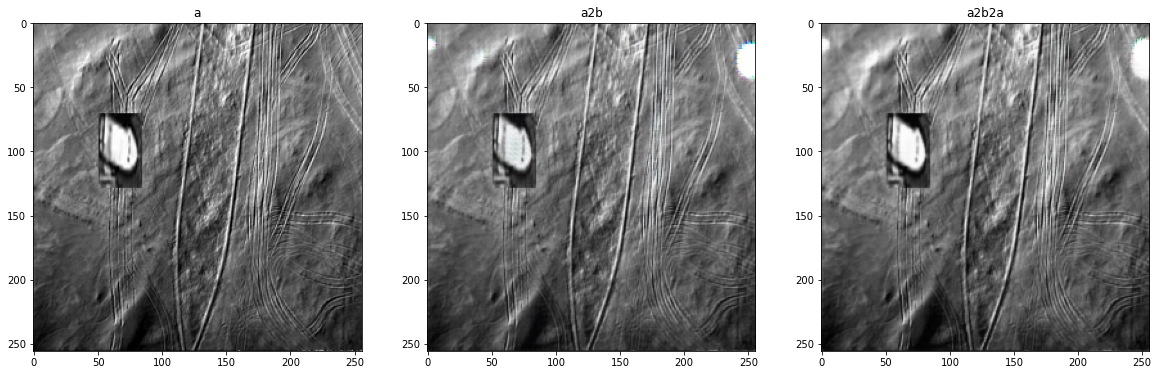

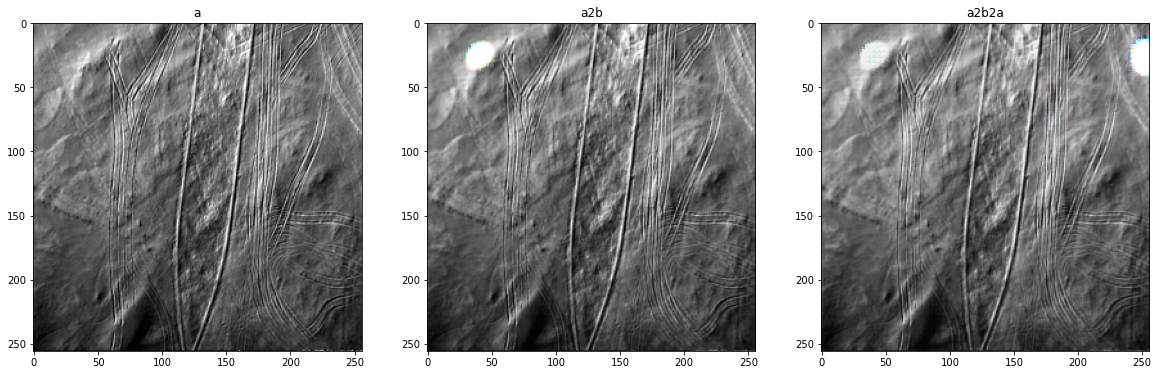

These iterations cost 408.503986120224 seconds


In [17]:
train(iterations=iterations, load_model=True)

In [ ]:
net_g1 = Generator().to(device)
net_g1.load_state_dict(T.load(path_work + 'net_g1.pt'))
net_g2 = Generator().to(device)
net_g2.load_state_dict(T.load(path_work + 'net_g2.pt'))
show(net_g1, net_g2)